In [55]:
%matplotlib inline
import warnings

import numpy as np
import matplotlib.pyplot as plt
from scipy.io import netcdf
import cartopy.crs as ccrs
import wrf

In [2]:
def stfunc_to_vorticity(psi, dx, dy):
    """
    stfunc = stream function
    
    Parameter:
    ---------
    psi: 2d-array, shape=(ny, nx)
        Stream Function.
    dx, dy: int or float
        The horizontal resolution.
    
    Return:
    ------
    Vorticity field.
    """
    ny, nx = psi.shape
    vorticity = np.zeros((nx, ny))
    for j in range(1, ny-1):
        for i in range(1, nx-1):
            vorticity[j,i] = ( (psi[j,i+1] - 2*psi[j,i] + psi[j,i-1]) / dx**2   
                               + (psi[j+1,i] - 2*psi[j,i] + psi[j-1,i]) / dy**2 )
    vorticity[0,:] = vorticity[1,:]
    vorticity[-1,:] = vorticity[-2,:]
    vorticity[:,0] = vorticity[:,1]
    vorticity[:,-1] = vorticity[:,-2]
    return vorticity

In [3]:
def laplace_relaxation(Z_init, Y, dx, dy, alpha=0.5, epsilon=0.02, max_iter=500):
    """
    Given Y, solve Z which satisfy Laplacian(Z)=Y.
    The boundary of Z would be set to 0.
    """
    Z = Z_init
    ny, nx = Z.shape
    residual = np.zeros((ny, nx))
    
    n_iter = 0
    while True:
        for j in range(1, ny-1):
            for i in range(1, nx-1):
                residual[j,i] = ( (Z[j,i+1] - 2*Z[j,i] + Z[j,i-1]) / dx**2
                                  + (Z[j+1,i] - 2*Z[j,i] + Z[j-1,i]) / dy**2 
                                  - Y[j,i] )
        dZ = (1+alpha) * residual / (2 * (1/dx**2 + 1/dy**2))
        Z += dZ
        n_iter += 1
        
        if np.all(np.abs(dZ) < epsilon):
            break
        elif n_iter >= max_iter:
            warnings.warn('The iteration has not converage.')
            break
            
    return Z

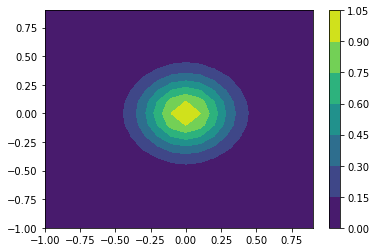

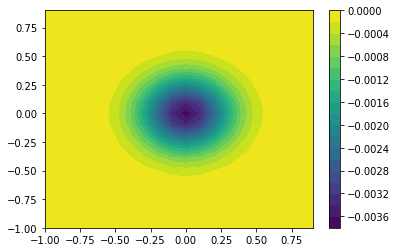

In [4]:
#http://ammar-hakim.org/sj/je/je1/je1-periodic-poisson.html
X, Y = np.meshgrid(np.arange(-1, 1, 0.1), np.arange(-1, 1, 0.1))
s = np.exp(-10 * X**2 - 10 *Y**2)
plt.contourf(X, Y, s)
plt.colorbar()

plt.figure()
Z_init = np.zeros_like(X)
res = laplace_relaxation(Z_init, s, 0.1, 0.1)
plt.contourf(X, Y, res, levels=20)
plt.colorbar()

### read wrf file

In [106]:
# read variables
ncfile = netcdf.netcdf_file('../MY_WRF_test/wrfout_d01_2017-08-21_00_00_00')
lat = ncfile.variables['XLAT'].data    # shape = (time, y, x) = (17, 66, 81)
lon = ncfile.variables['XLONG'].data
p = ncfile.variables['P'].data + ncfile.variables['PB'].data
p *= 0.01   # Pa to hPa

# get vorticity data
f = ncfile.variables['F'][:]   # shape = (time, y, x) = (17, 66, 81)
avo = wrf.getvar(ncfile, 'avo', wrf.ALL_TIMES)  # shape = (time, z, y, x) = (17, 29, 66, 81)
print('Befor dealing, unit of avo: ', avo.units)
avo = avo.values
avo *= 10**-5
vorticity = avo - f[:,np.newaxis,:,:]   # shape = (time, z, y, x) = (17, 29, 66, 81)

# interp vorticity into 850 hPa
vort850 = wrf.interpz3d(vorticity, p, np.array([850]), missing=np.nan)  # shape = (time, z, y, x) = (17, 1, 66, 81)

Befor dealing, unit of avo:  10-5 s-1


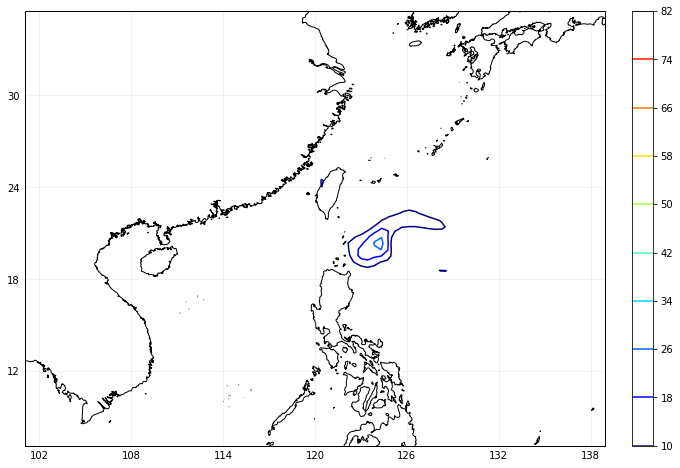

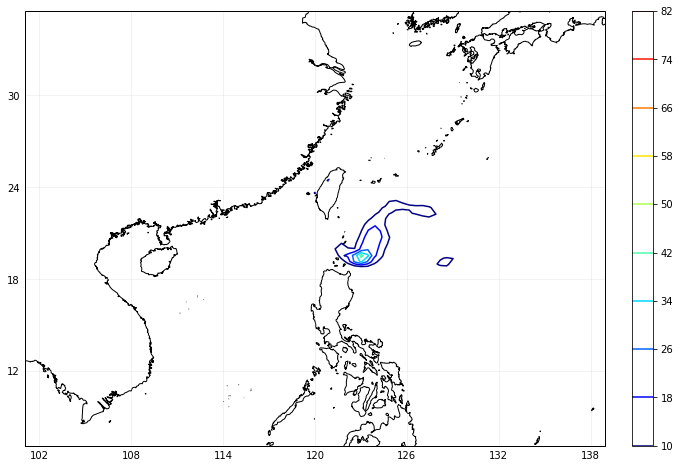

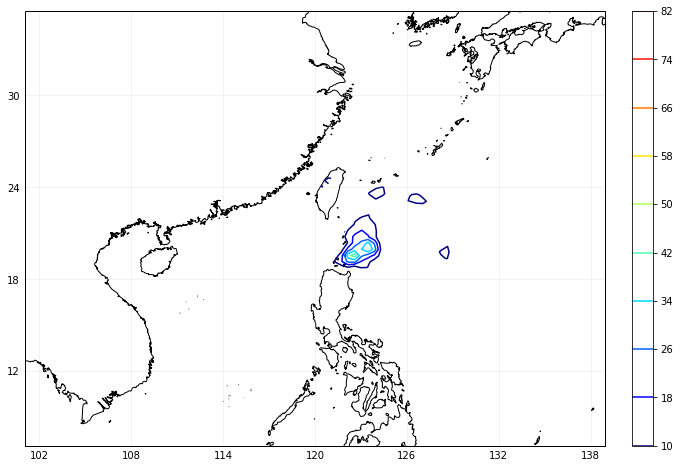

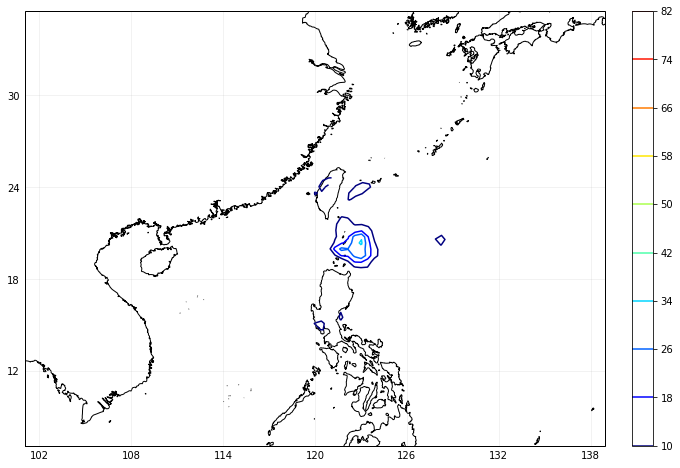

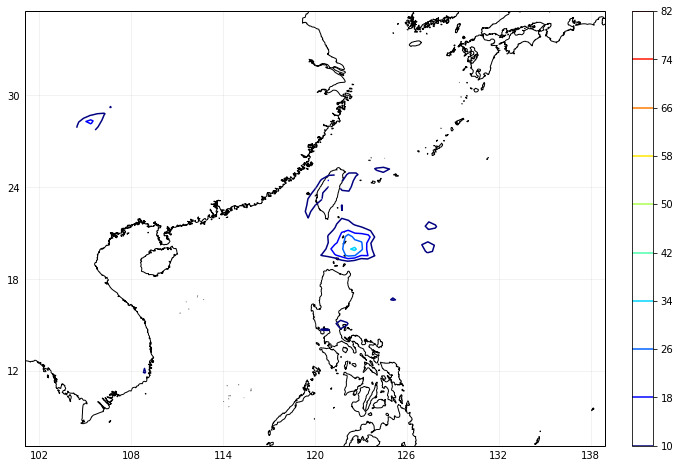

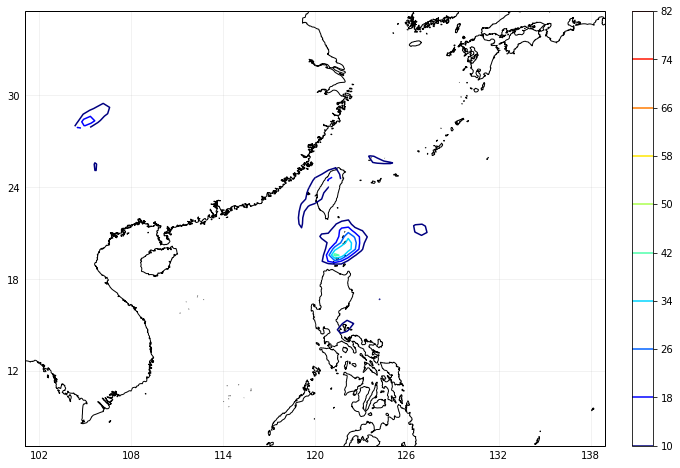

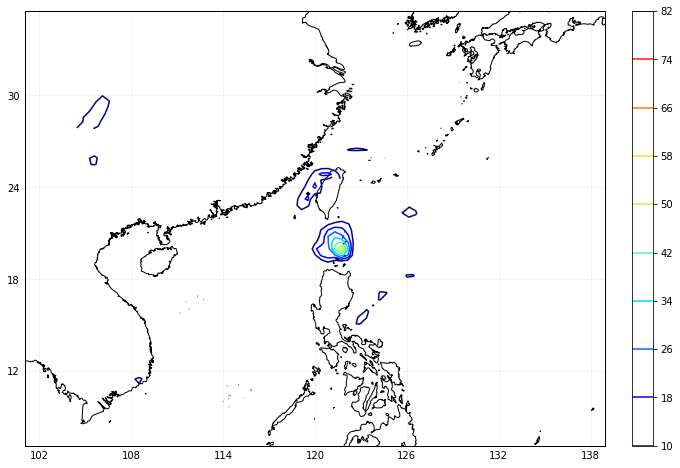

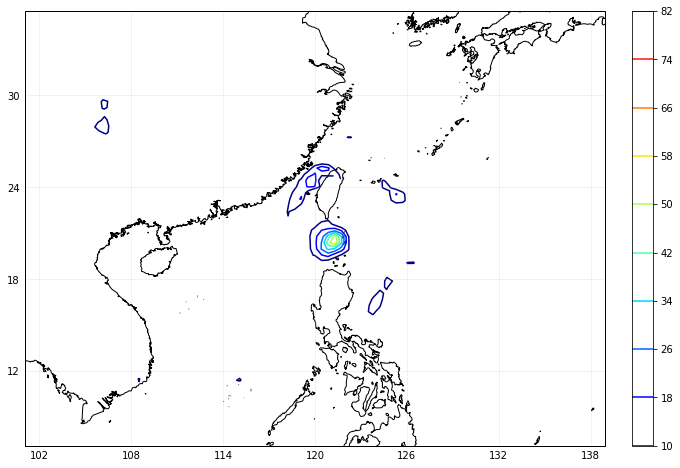

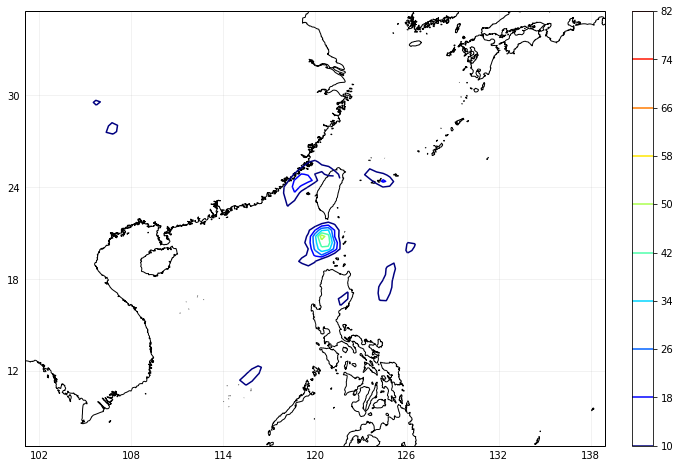

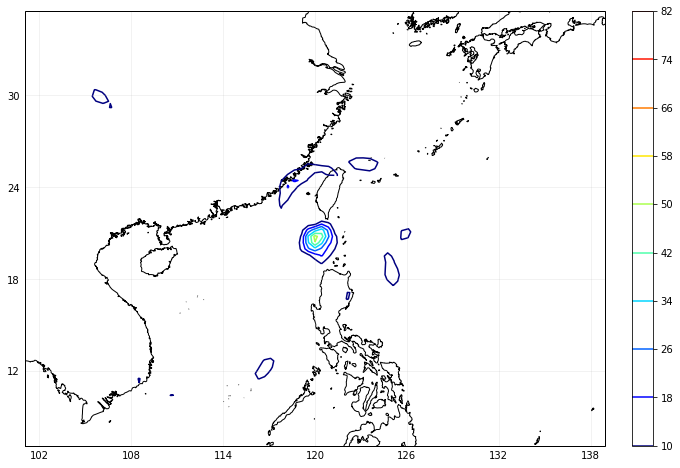

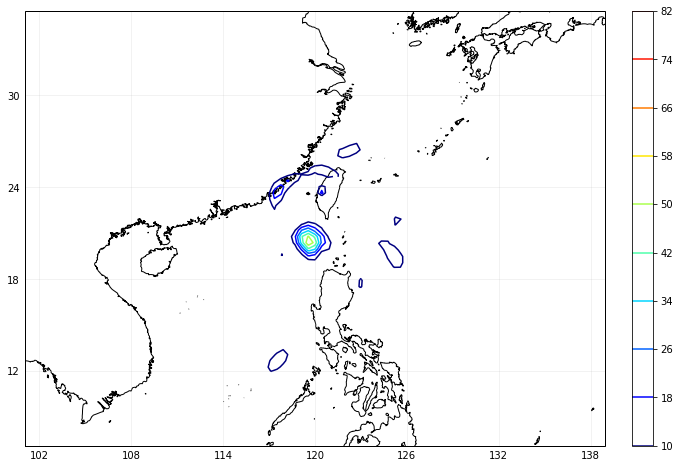

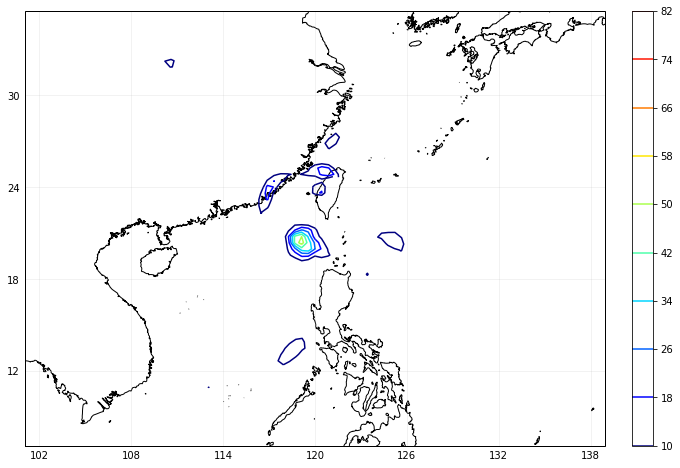

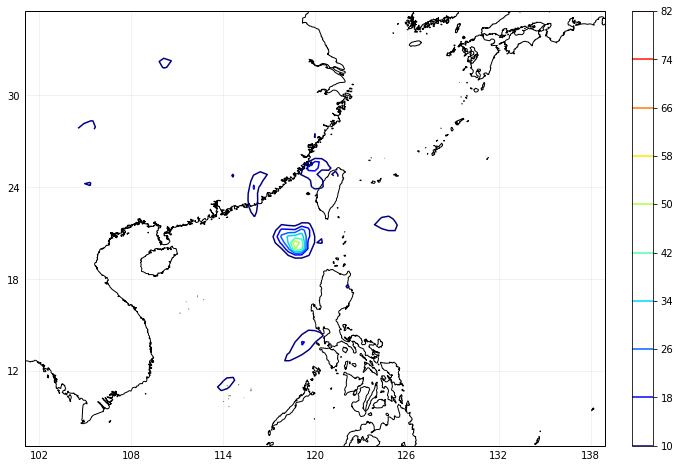

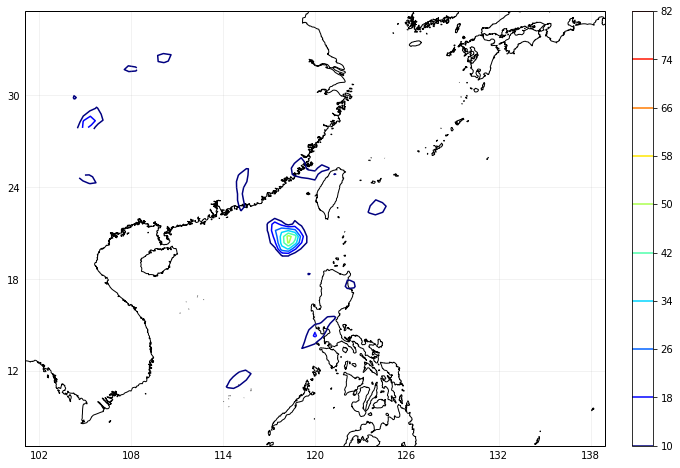

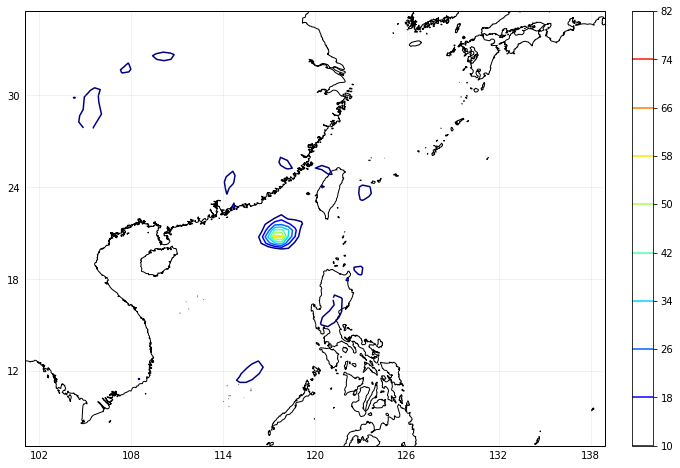

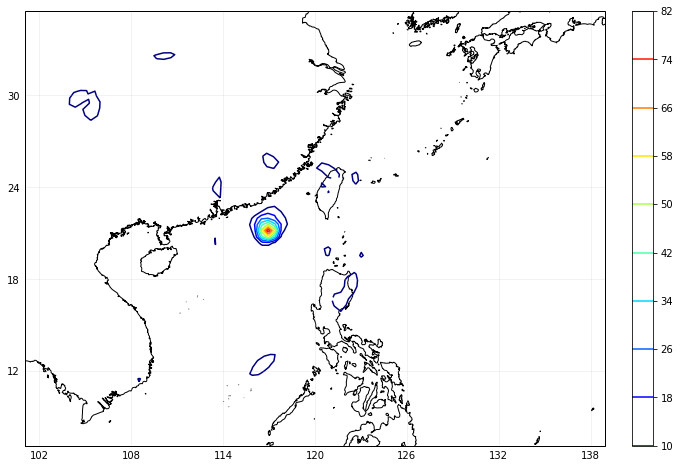

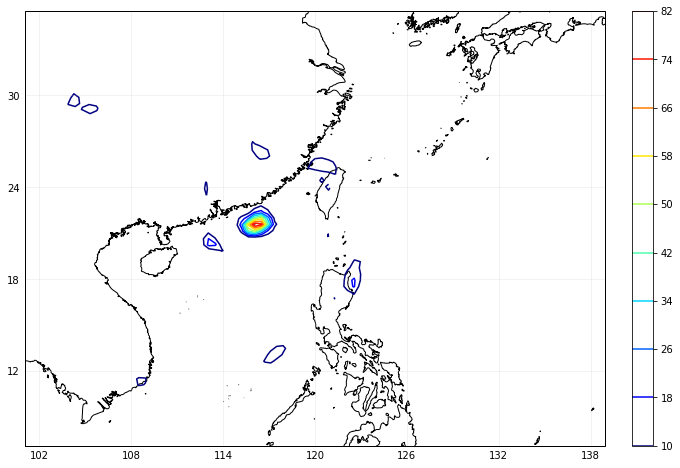

In [113]:
for itime in range(17):
    fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.set_extent([lon.min(), lon.max(), lat.min(), lat.max()])
    ax.coastlines(resolution='10m')
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, alpha=0.2)
    gl.xlabels_top = False
    gl.ylabels_right = False

    #itime = 0
    cn = ax.contour(lon[0], lat[0], 10**5 * vort850[itime,0,:,:], cmap='jet', levels=np.arange(10, 90, 8))
    plt.colorbar(cn, fraction=0.046, pad=0.04)

### Test 2d baratropical

In [130]:
isnan = np.isnan(vort850.values).ravel()
tmp = vort850.values.ravel()
tmp[isnan] = 0
tmp = tmp.reshape(vort850.shape)
tmp.shape

(17, 1, 66, 81)

In [141]:
#laplace_relaxation(np.zeros_like(tmp[0,0,:,:]), tmp[0,0,:,:], 45000, 45000)